# Linear Regression Lab 6 NLP
### OUTLINE
1. Data Preprocessing
    * Exploring data
    * Correcting dtypes
    * Handle missing values
    * Handle outliers
    * Feature engineering
    * Normalization
2. Linear Regression Model
3. Result

In [101]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gdown
from PIL import Image

In [102]:
based_url = 'https://drive.google.com/uc?id='
zip_path = 'home-data-for-ml-course.zip'
dir_name = 'data'
if not os.path.exists(zip_path):
    url = f'{based_url}1KX2X208q7ZlNSYhM8nKiu0s5ybhkIDv-'
    gdown.download(url, zip_path, quiet=False)
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir_name)
        print('Extracted')
file_path = f'{dir_name}/train.csv'
df = pd.read_csv(file_path)
test = pd.read_csv(f'{dir_name}/test.csv')
orig_rows_test = test.shape[0]
orig_test_id = test['Id']

## 1. Data Preprocessing

Some observatinons:

Fix incorrect datatype:
* MSSubClass: int64 --> string (cateogry)

In [103]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [104]:
print(df.head(5))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

### Exploring data

In [105]:
percentage = (test['Utilities'].eq('NoSeWa').mean()) * 100
print(f"Percentage of 'NoSeWa' in Utilities column: {percentage:.2f}%")

Percentage of 'NoSeWa' in Utilities column: 0.00%


In [106]:
def check_range(df1, df2, cols):
    for col in cols:
        set1 = set(df1[col].unique())
        set2 = set(df2[col].unique())
        diff = set1.difference(set2)
        diff2 = {}
        # diff2 = set2.difference(set1)
        lst = set(diff).union(set(diff2))
        if len(lst) > 0:
            print(f'{col} has different values in train and test datasets: {lst}')

# all_cols = set(df.columns) - set(['SalePrice'])
all_cols = df.select_dtypes(include=[object]).columns
check_range(df, test, all_cols)


Utilities has different values in train and test datasets: {'NoSeWa'}
Condition2 has different values in train and test datasets: {'RRAe', 'RRNn', 'RRAn'}
HouseStyle has different values in train and test datasets: {'2.5Fin'}
RoofMatl has different values in train and test datasets: {'Roll', 'Membran', 'Metal', 'ClyTile'}
Exterior1st has different values in train and test datasets: {'ImStucc', 'Stone'}
Exterior2nd has different values in train and test datasets: {'Other'}
Heating has different values in train and test datasets: {'Floor', 'OthW'}
Electrical has different values in train and test datasets: {nan, 'Mix'}
GarageQual has different values in train and test datasets: {'Ex'}
PoolQC has different values in train and test datasets: {'Fa'}
MiscFeature has different values in train and test datasets: {'TenC'}


### Correct dtype

In [107]:
df['MSSubClass'] = df['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

### Handle special columns

There are some columns where 'NA' stand for a particular meaning.

They are:
* BsmtQual: NA	No Basement
* BsmtCond: //
* BsmtExposure: //
* BsmtFinType1: //
* BsmtFinType2: //
* FireplaceQu: NA No Fireplace
* GarageType: NA No Garage
* GarageFinish: //
* GarageQual: //
* GarageCond: //
* PoolQC: NA No pool
* Fence: No Fence
* MasVnrType: None --> No Masonry veneer


In [108]:
special_cols = ['Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MasVnrType']
edit_list = {'Al': 'No access','Bs': 'No bsmt', 'Ga':'No grg', 'Fi':'No frp', 'Po':'No pool', 'Fe':'No fence', 'Ma': 'No mv'}
for col in special_cols:
    value  = edit_list[col[:2]]
    df[col] = df[col].fillna(value=value)
    test[col] = test[col].fillna(value=value)

### Handle missing data

Strategy for train:
* For data missing more than threshold T --> remove
* Others: impute with mean, mode, median from train distribution

Strategy for test:
* Impute with mean, mode, median of from test distribution


In [109]:
def find_nulls(df):
    null_cols = {}
    for col in df.columns:
        null_cols[col] = round(int(df[col].isnull().sum()) / len(df) * 100,2)

    null_cols = {k: v for k, v in null_cols.items() if v > 0}
    return null_cols

null_cols = find_nulls(df)
null_cols_test = find_nulls(test)
print(f'Null_cols: {null_cols}')
print(f'Null_cols_test: {null_cols_test}')

Null_cols: {'LotFrontage': 17.74, 'MasVnrArea': 0.55, 'Electrical': 0.07, 'GarageYrBlt': 5.55, 'MiscFeature': 96.3}
Null_cols_test: {'MSZoning': 0.27, 'LotFrontage': 15.56, 'Utilities': 0.14, 'Exterior1st': 0.07, 'Exterior2nd': 0.07, 'MasVnrArea': 1.03, 'BsmtFinSF1': 0.07, 'BsmtFinSF2': 0.07, 'BsmtUnfSF': 0.07, 'TotalBsmtSF': 0.07, 'BsmtFullBath': 0.14, 'BsmtHalfBath': 0.14, 'KitchenQual': 0.07, 'Functional': 0.14, 'GarageYrBlt': 5.35, 'GarageCars': 0.07, 'GarageArea': 0.07, 'MiscFeature': 96.5, 'SaleType': 0.07}


In [110]:
threshold = 80
drop_cols  = list(filter(lambda x: null_cols[x] > threshold, null_cols)) + ['Id', 'MiscVal'] #misval associate with MiscFeature
df = df.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)
null_cols = find_nulls(df)
null_cols_test = find_nulls(test)

In [111]:
def fill_nulls(df,cols,fill_type):
    for col in cols:
        if fill_type == 'mean':
            df[col] = df[col].fillna(df[col].mean())
        elif fill_type == 'mode':
            df[col] = df[col].fillna(df[col].mode()[0])
        elif fill_type == 'median':
            try:
                df[col] = df[col].fillna(df[col].median())
            except:
                print(f'Error in {col}')
        else:
            df[col] = df[col].fillna(fill_type)
    return df

train_fill_mode = ['Electrical']
train_fill_mean = ['LotFrontage']
train_fill_median = ['MasVnrArea', 'GarageYrBlt']
test_fill_mode = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']
test_fill_mean = ['LotFrontage','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
test_fill_median = ['MasVnrArea', 'GarageYrBlt']
assert len(train_fill_mode) + len(train_fill_mean) + len(train_fill_median) == len(null_cols)
assert len(test_fill_mode) + len(test_fill_mean) + len(test_fill_median) == len(null_cols_test)

def fill_nulls_wrapper(df,lists):
    df = fill_nulls(df,lists[0],'mode')
    df = fill_nulls(df,lists[1],'mean')
    df = fill_nulls(df,lists[2],'median')
    return df

df = fill_nulls_wrapper(df,[train_fill_mode,train_fill_mean,train_fill_median])
test = fill_nulls_wrapper(test,[test_fill_mode, test_fill_mean, test_fill_median])



### Handle outliers

IQR for skewed

Zscore for normally distributed

In [112]:
df2 = df.copy()

In [113]:
normal_cols = ['LotFrontage']
skew_cols = ['GrLivArea','LotArea','GarageArea','1stFlrSF','SalePrice']

def transform_skew(df, cols):
    for col in cols:
        df[col] = np.log1p(df[col])
    return df

def handling_outlier(df, cols, type='zscore'):
    if type == 'IQR':
        for col in cols:
            Q1 = df2[col].quantile(0.25)  
            Q3 = df2[col].quantile(0.75)  
            IQR = Q3 - Q1  
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)] # removing outliers
    elif type == 'zscore':
        for col in cols:
            z = (df[col] - df[col].mean()) / df[col].std()
            df = df[np.abs(z) < 3]
    return df


df2 = transform_skew(df2, skew_cols)
test = transform_skew(test, skew_cols[:-1])
df3 = handling_outlier(df2, normal_cols + skew_cols)

### Feature Engineering

* One hot encoding + label encoding categorical features
* Remove highly correlated features (assumption of linear regression)
* Add features: Age

In [114]:
categorical_cols = df3.select_dtypes(include=['object']).columns
nomimal_cols = ['Street','CentralAir']#Street_Pave, CentralAir_Y
ordinal_cols = list(set(categorical_cols) - set(nomimal_cols))

In [115]:
from sklearn.preprocessing import LabelEncoder
df4 = pd.get_dummies(df3, columns=nomimal_cols,drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=nomimal_cols,drop_first=True, dtype=int)

label_enc = LabelEncoder()
for col in ordinal_cols:
    df4[col] = label_enc.fit_transform(df4[col])
    test[col] = label_enc.fit_transform(test[col])
Y_train = df4['SalePrice']
df4 = df4.drop(columns=['SalePrice'])
assert df4.shape[1] == test.shape[1]
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1321 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1321 non-null   int64  
 1   MSZoning       1321 non-null   int64  
 2   LotFrontage    1321 non-null   float64
 3   LotArea        1321 non-null   float64
 4   Alley          1321 non-null   int64  
 5   LotShape       1321 non-null   int64  
 6   LandContour    1321 non-null   int64  
 7   Utilities      1321 non-null   int64  
 8   LotConfig      1321 non-null   int64  
 9   LandSlope      1321 non-null   int64  
 10  Neighborhood   1321 non-null   int64  
 11  Condition1     1321 non-null   int64  
 12  Condition2     1321 non-null   int64  
 13  BldgType       1321 non-null   int64  
 14  HouseStyle     1321 non-null   int64  
 15  OverallQual    1321 non-null   int64  
 16  OverallCond    1321 non-null   int64  
 17  YearBuilt      1321 non-null   int64  
 18  YearRemodAdd 

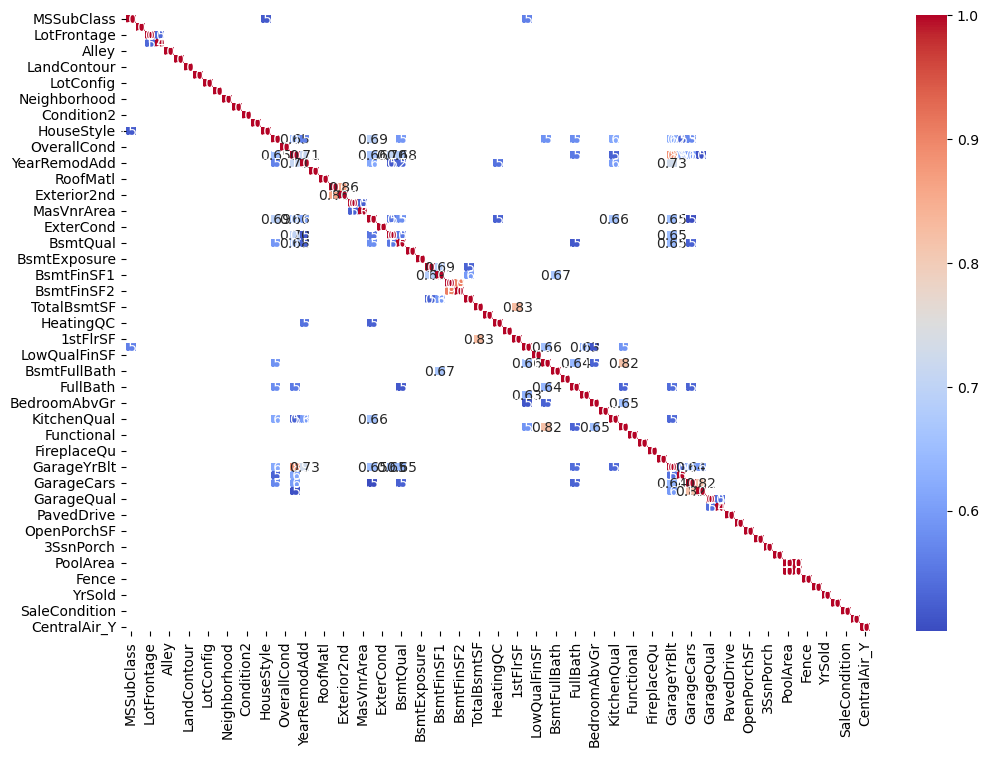

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df4.corr(method='spearman').abs()  # Compute absolute correlation values
filtered_corr = corr_matrix[corr_matrix > 0.5]  # Keep only correlations > 0.5

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()



In [117]:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print("Highly correlated features to drop:", to_drop)
df4 = df4.drop(columns=to_drop)
test = test.drop(columns=to_drop)

Highly correlated features to drop: ['Exterior2nd', 'BsmtFinSF2', 'GarageYrBlt', 'PoolQC']


### Normalization

In [118]:
numeric_cols = list(set(df4.select_dtypes(include=['int64', 'float64']).columns) - set(nomimal_cols) - set(ordinal_cols) - set(['SalePrice']))
print(numeric_cols)

['Street_Pave', 'OverallQual', '3SsnPorch', 'LowQualFinSF', 'BsmtFinSF1', 'LotArea', 'BsmtUnfSF', 'Fireplaces', 'HalfBath', 'PoolArea', 'YearBuilt', 'MoSold', 'EnclosedPorch', 'TotRmsAbvGrd', 'CentralAir_Y', 'OverallCond', '1stFlrSF', 'LotFrontage', 'MasVnrArea', 'TotalBsmtSF', 'GarageCars', 'YrSold', 'BsmtHalfBath', 'GarageArea', 'GrLivArea', 'KitchenAbvGr', 'OpenPorchSF', 'WoodDeckSF', 'ScreenPorch', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFullBath', 'YearRemodAdd', 'FullBath']


In [119]:
num_features_std = ['1stFlrSF', 'LotFrontage', 'LotArea']
num_features_minmax = ['MasVnrArea', 'ScreenPorch', 'EnclosedPorch', 'BsmtFinSF1', 
                        'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'PoolArea',
                        'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold']
preprocessor = ColumnTransformer([
    ('std', StandardScaler(), num_features_std),
    ('minmax', MinMaxScaler(), num_features_minmax)
], remainder='passthrough')  # Keep other columns unchanged

df_train_scaled = preprocessor.fit_transform(df4)
df_test_scaled = preprocessor.transform(test)


transformed_columns = num_features_std + num_features_minmax  # Only transformed columns
other_columns = [col for col in df4.columns if col not in transformed_columns]  # Unchanged columns
new_column_order = transformed_columns + other_columns  

df_train_scaled = pd.DataFrame(df_train_scaled, columns=new_column_order)
df_test_scaled = pd.DataFrame(df_test_scaled, columns=new_column_order)


In [120]:
assert df_train_scaled.shape[1] == df_test_scaled.shape[1]
assert df_train_scaled.shape[0] == Y_train.shape[0]
assert not df_train_scaled.select_dtypes(exclude=['number']).columns.tolist() 
assert not df_test_scaled.select_dtypes(exclude=['number']).columns.tolist()

### Train test split

In [121]:
from sklearn.model_selection import train_test_split
X_train = df_train_scaled.to_numpy()
X_test = df_test_scaled.to_numpy()
Y_train = Y_train.to_numpy().reshape(-1,1)
def print_shapes(lst):
    for x in lst:
        print(x.shape)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = X_train.T, X_val.T, Y_train.T, Y_val.T
print_shapes([X_train, Y_train, X_val, Y_val])

(73, 1188)
(1, 1188)
(73, 133)
(1, 133)


## 2. Linear Regression Model


Cost after 0 iterations: 73.77108549900173
Cost after 10000 iterations: 0.027112993724349426
Cost after 20000 iterations: 0.016346817605549
Cost after 30000 iterations: 0.010791313014960514
Cost after 40000 iterations: 0.00792455959730964
Cost after 50000 iterations: 0.006445202975030259
Cost after 60000 iterations: 0.00870922388884892
Cost after 70000 iterations: 0.005287863599971725
Cost after 80000 iterations: 0.005084581003292458
Cost after 90000 iterations: 0.004980968463325102
Cost after 100000 iterations: 0.004925558084289896
Cost after 110000 iterations: 0.004897627129318643
Cost after 120000 iterations: 0.004883214200779701
Cost after 130000 iterations: 0.004875776282569153
Cost after 140000 iterations: 0.004871937813970703
Cost after 150000 iterations: 0.5995925505601345
Cost after 160000 iterations: 0.004868936161542533
Cost after 170000 iterations: 0.005067494091374083
Cost after 180000 iterations: 0.004868136476370034
Cost after 190000 iterations: 0.004867995992348308
Cost

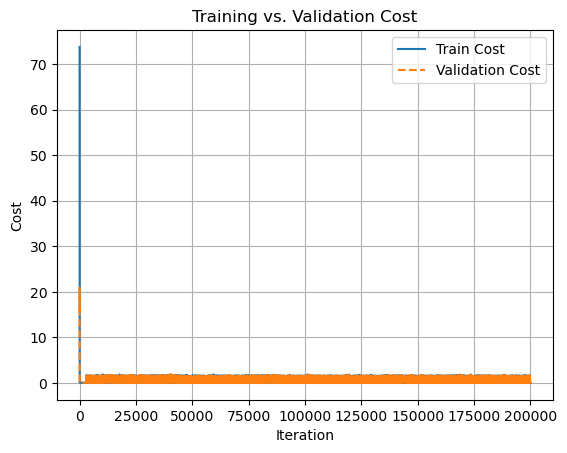

In [122]:
def compute_cost(Z, Y, W = None, regularizer = None, lambd = 0.7):
    m = Y.shape[1]
    cost = 1.0 / (2*m) * np.sum((Y - Z)**2)
    if regularizer == 'l2':
        cost = cost + lambd/(2*m)*np.sum(np.square(W))
    return cost

def forward(X, W, b):
    '''
    X: input data (n_x, m)
    W weights (1, n_x), a row is weights for all features
    b bias (1, 1), broadcasting will be applied
    '''
    Z = np.dot(W, X) + b
    cache = (X, W, b)
    return Z

def compute_grad(Z,Y,X,W,b,regularizer = 'l2', lambd = 0.7):
    '''
    Z: output of the forward pass (1, m)
    Y: true label (1, m)
    X: input data (n_x, m)
    '''
    m = Z.shape[1]
    dZ = 1.0/m*(Z-Y)
    dW = np.dot(dZ, X.T)
    db = np.sum(dZ)
    if regularizer == 'l2':
        dW = dW + lambd/m*W
    return (dW, db)

def update_params(W,b, grad, alpha = 0.001, optimizer ='Adam', beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8,  k= 0, m = None, v = None):
    '''
    m: shape of W
    v: shape of W
    '''
    (dW, db) = grad
    if optimizer == 'Adam':
        m = (1-beta1)*dW +beta1*m
        v = (1-beta2)*dW**2 + beta2*v
        m_hat = m/(1-beta1**k)
        v_hat = v/(1-beta2**k)
        W = W - alpha*m_hat/(np.sqrt(v_hat)+epsilon)
        b = b - alpha*db
        
    return (W,b,m,v)

def initialize_params(n_x):
    W = np.random.randn(1, n_x)*0.01
    b = np.zeros((1,1))
    return W,b

def linear_model(X,Y,learning_rate,regularizer ='l2', optimizer = 'Adam', adam_params = None, lambd = 0.7, n_itrs = 10000, print_cost = True, validate = True):

    #initialize parameters
    costs = []
    val_costs = []
    (n_x,m) = X.shape
    W,b = initialize_params(n_x)
    m = np.zeros_like(W)
    v = np.zeros_like(W)
    if adam_params:
        beta1 = adam_params['beta1']
        beta2 = adam_params['beta2']
        learning_rate = adam_params['learning_rate']
    
    #train
    for i in range(n_itrs):
        Z = forward(X,W,b)
        cost = compute_cost(Z,Y,W, regularizer, lambd)
        grad = compute_grad(Z,Y,X,W,b,regularizer, lambd)
        W,b,m,v= update_params(W,b,grad,learning_rate, optimizer,beta1=beta1,beta2=beta2, m=m, v=v, k = i+1)
        costs.append(cost)
        if i % 10000 == 0 or i == n_itrs - 1:
            print(f'Cost after {i} iterations: {cost}')

        #validation
        if validate:
            Z_val = forward(X_val,W,b)
            val_cost = compute_cost(Z_val,Y_val,W, regularizer, lambd)
            val_costs.append(val_cost)
    return W,b,costs, val_costs

def plot_costs(costs, val_costs):
    plt.plot(range(len(costs)), costs, label="Train Cost")
    plt.plot(range(len(val_costs)), val_costs, label="Validation Cost", linestyle="dashed")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.title("Training vs. Validation Cost")
    plt.legend()
    plt.grid(True)
    plt.show()

def predict(X,W,b):
    return np.expm1(np.dot(W,X) + b) #inverse of log1p
    # return np.dot(W,X) + b

np.random.seed(42)
adam_params = {'beta1':0.9, 'beta2':0.999, 'learning_rate':0.04}
W,b,costs,val_costs= linear_model(X_train,Y_train,learning_rate=0.01, n_itrs = 200000 , regularizer='l2', optimizer='Adam', lambd = 0.7,adam_params =adam_params)
#prev best linear_model(X_train,Y_train,learning_rate=0.001, n_itrs = 100000, regularizer='l2', optimizer='Adam', lambd = 0.7)
plot_costs(costs,val_costs)

In [127]:
train_preds = predict(X_train,W,b)
val_preds = predict(X_val,W,b)
train_mse = np.mean((np.expm1(Y_train) - train_preds)**2)
val_mse = np.mean((np.expm1(Y_val) - val_preds)**2)
print(f"Train MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")

Train MSE: 335311700.0367005
Validation MSE: 597927549.5353711


In [129]:
assert test.shape[0] == orig_rows_test
test_preds = predict(X_test.T,W,b)
submission = pd.DataFrame({'Id': orig_test_id, 'SalePrice': test_preds.flatten()})
submission.to_csv('submission.csv', index=False)
print(submission.head())

     Id      SalePrice
0  1461  123136.519681
1  1462  160331.668943
2  1463  178562.446464
3  1464  197542.208605
4  1465  193031.627806


In [125]:
print(submission.shape)
sum(submission['SalePrice'].isnull())

(1459, 2)


0

## 3. Result
Top 128 over 6990

It is quite weird that even when I let it overfit for 200k iterations, the result for test got better. Perhaps I made a mistake during normalization, and the distribution of test is similar to the distribution of train.

In [126]:
img_path = 'lab6_result.png'
if not os.path.exists(img_path):
    url = f'{based_url}1IrrlGIVHffrXfi1S-aCmK8PC5jUk-C3h'
    gdown.download(url, img_path, quiet=False)
img = Image.open(img_path)
img.show()